<a href="https://colab.research.google.com/github/afrozmaria07/anomalyDetection-DBSCAN-PID-GAM-PCA/blob/main/test_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Anomaly detection using an Supervised Autoencoder -->

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
import arff

# Load datasets
folder_path = 'data'
dataset_files = ['thyroid.mat', 'mammography.mat', 'mammography_noisy50.mat','musk.mat','satimage-2.mat', 'siesmic.mat']


In [ ]:
def load_data(file_path, file_type):
    if file_type == ".mat":
        mat_data = loadmat(file_path)
        if 'X' in mat_data and 'y' in mat_data:
            X = pd.DataFrame(mat_data['X'])
            y = pd.Series(mat_data['y'].flatten())  # Convert labels to 1D
            return X, y
        else:
            print(f"Unexpected structure in {file_path}: {mat_data.keys()}")
            return pd.DataFrame(), pd.Series()
    elif file_type == ".arff":
        with open(file_path) as f:
            arff_data = arff.load(f)
        data = np.array(arff_data['data'])
        X = pd.DataFrame(data[:, :-1])
        y = pd.Series(data[:, -1])
        return X, y
    else:
        print(f"Unsupported file type: {file_type}")
        return pd.DataFrame(), pd.Series()

In [ ]:

# Load and preprocess all datasets
def load_and_preprocess_all_data(folder_path, dataset_files):
    combined_X = pd.DataFrame()
    combined_y = pd.Series(dtype=np.float64)

    for file in dataset_files:
        file_path = os.path.join(folder_path, file)
        file_extension = os.path.splitext(file)[-1]

        X, y = load_data(file_path, file_extension)
        if not X.empty and not y.empty:
            combined_X = pd.concat([combined_X, X], ignore_index=True)
            combined_y = pd.concat([combined_y, y], ignore_index=True)
        else:
            print(f"Skipped file {file} due to empty data.")

    return combined_X, combined_y

In [ ]:
# Load the data
combined_X, combined_y = load_and_preprocess_all_data(folder_path, dataset_files)

# Check the shapes of combined_X and combined_y
print(f"Shape of combined_X: {combined_X.shape}")
print(f"Shape of combined_y: {combined_y.shape}")


Shape of combined_X: (41015, 166)
Shape of combined_y: (41015,)


/tmp/ipykernel_37745/2947041725.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_y = pd.concat([combined_y, y], ignore_index=True)


In [ ]:
# Preprocessing the data
# Label encoding the target variable (if categorical)
le = LabelEncoder()
y_encoded = le.fit_transform(combined_y)

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_X, y_encoded, test_size=0.3, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Build the Supervised Autoencoder model
input_dim = X_train_scaled.shape[1]  # Number of features
latent_dim = 16  # Dimension of the latent space

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(inputs)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)  # Output layer matches input_dim

# Classification head
classifier_output = layers.Dense(1, activation='sigmoid')(encoded)  # For binary classification

# Autoencoder model (combining encoder and decoder)
autoencoder = models.Model(inputs=inputs, outputs=[decoded, classifier_output])


In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam',
                    loss=['mse', 'binary_crossentropy'],
                    loss_weights=[0.5, 0.5],
                    metrics=['accuracy'])


In [ ]:
# Train the autoencoder
history = autoencoder.fit(X_train_scaled, [X_train_scaled, y_train],
                          epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, [X_test_scaled, y_test]))


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - dense_10_accuracy: 0.9635 - dense_10_loss: 0.3016 - dense_9_loss: nan - dense_9_mae: nan - loss: nan - val_dense_10_accuracy: 0.9665 - val_dense_10_loss: 0.1989 - val_dense_9_loss: nan - val_dense_9_mae: nan - val_loss: nan
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_10_accuracy: 0.9667 - dense_10_loss: 0.1785 - dense_9_loss: nan - dense_9_mae: nan - loss: nan - val_dense_10_accuracy: 0.9665 - val_dense_10_loss: 0.1318 - val_dense_9_loss: nan - val_dense_9_mae: nan - val_loss: nan
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_10_accuracy: 0.9654 - dense_10_loss: 0.1233 - dense_9_loss: nan - dense_9_mae: nan - loss: nan - val_dense_10_accuracy: 0.9665 - val_dense_10_loss: 0.1003 - val_dense_9_loss: nan - val_dense_9_mae: nan - val_loss: nan
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - dense_10_accuracy: 0.9663 - dense_10_loss: 0.0960 - dense_9_loss: nan - dense_9_mae: nan - loss: nan - val_den

In [ ]:
# Make predictions
_, y_pred_prob = autoencoder.predict(X_test_scaled)

# Convert probabilities to class labels (threshold 0.5 for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


In [ ]:

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.9665176757415684
F1 Score: 0.0


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

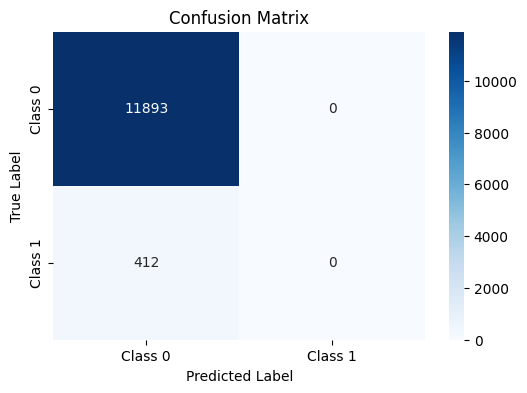

In [ ]:
# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()